# Implementing Yann LeCun's LeNet-5 in PyTorch

## Setup

In [22]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as functional
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset


import matplotlib.pyplot as plt
import random

import pandas as pd

from PIL import Image
import os
from tqdm import tqdm
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [23]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 32
ROW_IMG = 10
N_ROWS = 10

## Helper Functions

In [24]:
Num2Later = {0: 'А',
             1: 'Б',
             2: 'В',
             3: 'Г',
             4: 'Д',
             5: 'Е',
             6: 'Ж',
             7: 'З',
             8: 'И',
             9: 'Й',
             10: 'К',
             11: 'Л',
             12: 'М',
             13: 'Н',
             14: 'О',
             15: 'П',
             16: 'Р',
             17: 'С',
             18: 'Т',
             19: 'У',
             20: 'Ф',
             21: 'Х',
             22: 'Ц',
             23: 'Ч',
             24: 'Ш',
             25: 'Щ',
             26: 'Ъ',
             27: 'Ы',
             28: 'Ь',
             29: 'Э',
             30: 'Ю',
             31: 'Я'}





def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    # plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in tqdm(train_loader):
        

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, model_name, print_every=1 ):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
        torch.save(model.state_dict(), f"{model_name}\\curent.pth")
            
        if epoch > 1:
            if valid_losses[epoch]<valid_losses[epoch-1]:
                torch.save(model.state_dict(), f"{model_name}\\best{epoch}.pth")
                print(f'best model was saved with: '
                  f'Train loss: {train_loss:.4f}\n'
                  f'Valid loss: {valid_loss:.4f}\n'
                  f'Train accuracy: {100 * train_acc:.2f}\n'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

## Data

In [25]:
class CyrillicDataset(Dataset):
    def __init__(self, root, csv, transform):
        self.root = root
        self.csv = pd.read_csv(csv)
        self.transform = transform  

        print(len(self.csv['label'].unique()))

    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, i):
        img_path = f"{self.root}/{self.csv.iloc[i, 1]}"  # Лучше "/" для кроссплатформенности
        img = Image.open(img_path).convert("L")  # Преобразуем в градации серого

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.csv.iloc[i, 2], dtype=torch.long)  # Правильный тип

        return img, label




transformss = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.RandomHorizontalFlip(),  # Случайный горизонтальный поворот
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Изменение яркости/контраста
    transforms.ToTensor(),
])


data = CyrillicDataset('Cyrillic_unpacked', 'labels.csv', transformss)
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = data.csv['imageName'].values  
y = data.csv['label'].values  

for train_idx, val_idx in skf.split(X, y):
    train_dataset = torch.utils.data.Subset(data, train_idx)
    valid_dataset = torch.utils.data.Subset(data, val_idx)
    break  # Берем только первую итерацию

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


32


In [26]:
def get_efficientnet_model(num_classes=32):
    # Загружаем предобученную модель EfficientNet-B0
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    
    # Изменяем первый свёрточный слой для работы с 1-канальными изображениями
    in_channels = 1
    out_channels = model.features[0][0].out_channels
    kernel_size = model.features[0][0].kernel_size
    stride = model.features[0][0].stride
    padding = model.features[0][0].padding
    
    model.features[0][0] = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

    # Заменяем последний слой классификатора
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    
    return model

torch.manual_seed(RANDOM_SEED)
efficientnet_model = get_efficientnet_model()
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [27]:

optimizer_effnet = torch.optim.AdamW(efficientnet_model.parameters(), lr=1e-4, weight_decay=1e-3)

efficientnet_model, optimizer_effnet, _ = training_loop(efficientnet_model, criterion, optimizer_effnet, train_loader, valid_loader, N_EPOCHS, DEVICE, model_name="effNet")

100%|██████████| 96/96 [00:41<00:00,  2.30it/s]


19:40:27 --- Epoch: 0	Train loss: 3.5052	Valid loss: 3.7670	Train accuracy: 3.78	Valid accuracy: 3.77


 92%|█████████▏| 352/381 [09:31<00:47,  1.62s/it]


KeyboardInterrupt: 

**Evaluating the predictions**

C:\Temp\ipykernel_2088\2844430646.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('effNet\\best.pth', map_location=torch.device('cpu'))


Text(0.5, 0.98, 'LeNet-5 - predictions')

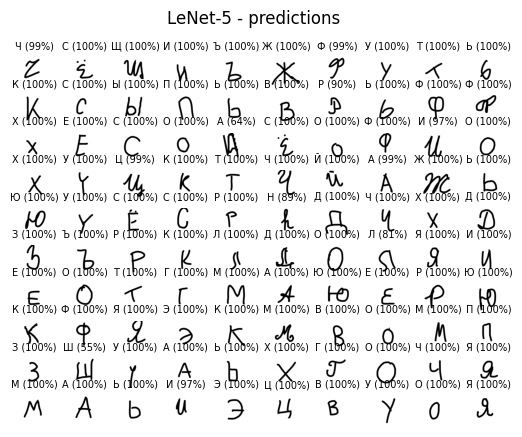

In [21]:
model = get_efficientnet_model()
state_dict = torch.load('effNet\\best.pth', map_location=torch.device('cpu'))  
model.load_state_dict(state_dict)
model.eval()  # Переключаем в режим инференса

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    image, _ = valid_dataset[index]  # Получаем изображение
    image = image.squeeze()
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(image, cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        image = image.unsqueeze(0).unsqueeze(0)  # Делаем 4D
        logits = model(image)  
        probs = torch.softmax(logits, dim=1)  # Преобразуем логиты в вероятности
        
    title = f'{Num2Later[int(probs.argmax())]} ({probs.max().item() * 100:.0f}%)'
    plt.title(title, fontsize=7)

fig.suptitle('LeNet-5 - predictions')


C:\Temp\ipykernel_2088\4112756036.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('effNet\\best.pth', map_location=torch.device('cpu'))


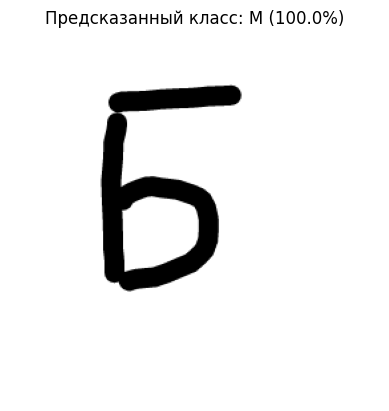

In [50]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Загрузка модели


IMG_SIZE = 256  # Размер входного изображения
model = get_efficientnet_model()
state_dict = torch.load('effNet\\best.pth', map_location=torch.device('cpu'))  
model.load_state_dict(state_dict)
model.eval()  # Переключаем в режим инференса

# Преобразования (Resize -> Grayscale -> ToTensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Загружаем изображение
image_path = 'Cyrillic_unpacked\\58c13f63bc581.png'
image, _ = valid_dataset[1005]  # Получаем изображение
image = image.squeeze()
image = image.unsqueeze(0)  # (1, 256, 256)
image = image.unsqueeze(0)  # (1, 1, 256, 256)

# Предсказание модели
with torch.no_grad():  
    model.eval()
    logits = model(image)  
    probs = torch.softmax(logits, dim=1)  # Преобразуем логиты в вероятности

# Отображение изображения и предсказанного класса
plt.imshow(Image.open(image_path), cmap='gray')
plt.title(f'Предсказанный класс: {Num2Later[int(probs.argmax())]} ({probs.max().item()*100:.1f}%)')
plt.axis('off')
plt.show()
